# Importing necessary libraries

In [1]:
import pandas as pd
import re
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

2025-06-20 14:38:48.134686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750430328.371221      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750430328.443816      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading and preprocessing the UTKFace dataset

In [2]:
# Set the image directory
img_dir = '/kaggle/input/utkface-new/UTKFace'

# List all image file paths
image_files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')]

# Parse attributes from filenames and store in a DataFrame
def parse_filename(filename):
    basename = os.path.basename(filename)
    match = re.match(r'(\d+)_(\d)_(\d)_.*\.jpg', basename)
    if match:
        age = int(match.group(1))
        gender = int(match.group(2))
        race = int(match.group(3))
        return age, gender, race
    else:
        return None, None, None

# Build a list of parsed data
parsed_data = [parse_filename(f) + (f,) for f in image_files if parse_filename(f)[0] is not None]

# Convert to DataFrame
df = pd.DataFrame(parsed_data, columns=['age', 'gender', 'race', 'file_path'])

# Remove NA
df = df.dropna().reset_index(drop=True)

# Split into train/val/test (e.g., 80/10/10 split)
train_df, val_test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['gender']
)
val_df, test_df = train_test_split(
    val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['gender']
)

# Extract file paths
train_files = train_df['file_path'].tolist()
val_files = val_df['file_path'].tolist()
test_files = test_df['file_path'].tolist()

# Preprocessing function for images
def load_and_preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0, 1]
    img = tf.image.resize(img, [64, 64])
    return img, img

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(val_files)
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1750430366.762101      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750430366.762867      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Loading a previously trained and saved autoencoder (to save time and skip the training process)

In [3]:
# Loading a saved autoencoder
autoencoder = load_model('/kaggle/input/utkface-autoencoders/autoencoder_32_30.keras')
encoder = load_model('/kaggle/input/utkface-autoencoders/autoencoder_encoder_32_30.keras')
decoder = load_model('/kaggle/input/utkface-autoencoders/autoencoder_decoder_32_30.keras')

encoder.summary()
decoder.summary()
autoencoder.summary()

# Storing the weights of the first layer of the decoder for usage after rotation of latent space
W, bias = decoder.layers[1].get_weights()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         262,176 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,552 (1.36 MB)

 Trainable params: 355,488 (1.36 MB)

 Non-trainable params: 64 (256.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_6CLONE (InputLayer)     │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8192)                │         270,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 511,043 (1.95 MB)

 Trainable params: 511,043 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 32)                  │         355,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 64, 64, 3)           │         511,043 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,599,659 (9.92 MB)

 Trainable params: 866,531 (3.31 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 1,733,064 (6.61 MB)

# Define the autoencoder (Not required if a previously trained and saved autoencoder is loaded before)

In [16]:
# Encoder
input_img = layers.Input(shape=(64,64,3))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
x = layers.Flatten()(x) 
encoded = layers.Dense(32, activation='relu')(x)
encoder = Model(input_img, encoded)
encoder.summary()


# Decoder
x = layers.Dense(8 * 8 * 128, activation='relu')(encoded)
x = layers.Reshape((8, 8, 128))(x)
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
decoder = Model(encoded, decoded)
decoder.summary()

# Full Autoencoder
autoencoder_input = input_img
autoencoder_output = decoder(encoder(autoencoder_input))

# Compiling the Autoencoder
autoencoder = Model(autoencoder_input, autoencoder_output)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │         262,176 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,552 (1.36 MB)

 Trainable params: 355,488 (1.36 MB)

 Non-trainable params: 64 (256.00 B)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ keras_tensor_88CLONE (InputLayer)    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8192)                │         270,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 511,043 (1.95 MB)

 Trainable params: 511,043 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_3 (Functional)            │ (None, 32)                  │         355,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_4 (Functional)            │ (None, 64, 64, 3)           │         511,043 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 866,595 (3.31 MB)

 Trainable params: 866,531 (3.31 MB)

 Non-trainable params: 64 (256.00 B)

# Training and saving the autoencoder (Not required if a previously trained and saved autoencoder is loaded before)

In [17]:
# Setting up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training the Autoencoder
history = autoencoder.fit(train_dataset,
                          epochs=30,
                          validation_data = val_dataset,
                          callbacks = [early_stopping]
                         )

# Storing the weights of the first layer of the decoder for usage after rotation of latent space
W, bias = decoder.layers[1].get_weights()

# Saving the trained autoencoder for future use
autoencoder.save('/kaggle/working/autoencoder_32_30.keras')
encoder.save('/kaggle/working/autoencoder_encoder_32_30.keras')
decoder.save('/kaggle/working/autoencoder_decoder_32_30.keras')

Epoch 1/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0250 - val_loss: 0.0118
Epoch 2/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0125 - val_loss: 0.0105
Epoch 3/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0110 - val_loss: 0.0099
Epoch 4/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 5/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0099 - val_loss: 0.0095
Epoch 6/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 7/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 8/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 9/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0091 - val_loss: 0.0094
Epoch 10/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 11/30
592/592 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 12/30
592/592 ━━━━━━━━━━━━━━━━━━━━

# Evaluate and visualize

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


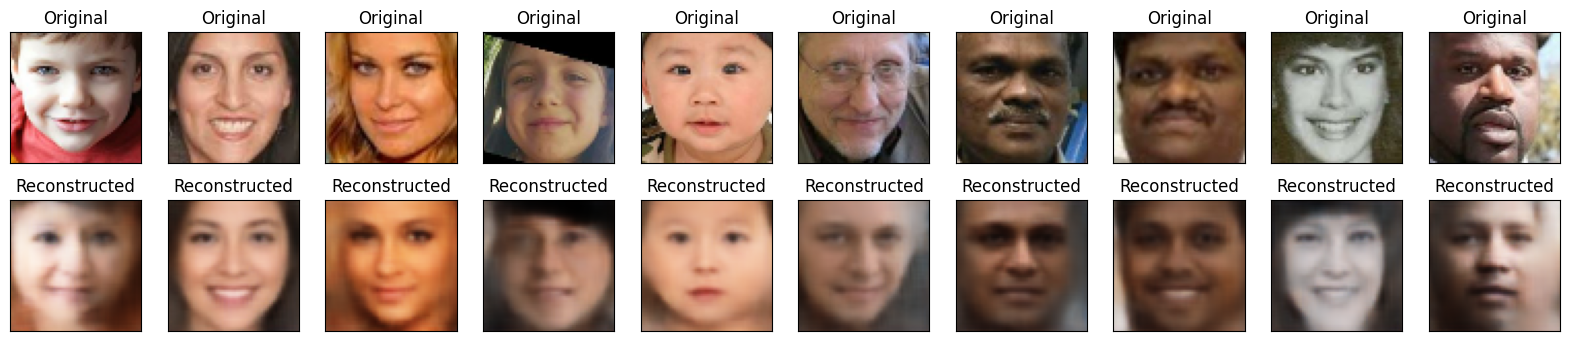

In [18]:
all_original_images = []
all_reconstructed_images = []

for images,_ in test_dataset.take(10):
    # Generate reconstructions
    reconstructed_images = autoencoder.predict(images)
    
    # Collect images and their reconstructions
    all_original_images.extend(images.numpy())
    all_reconstructed_images.extend(reconstructed_images)


# Function to display the original and reconstructed images  
def show_reconstructed_images(original_images, reconstructed_images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(min(n, len(original_images))):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.savefig('autoencoder_ip_op.png')
    plt.show()

show_reconstructed_images(all_original_images[:10], all_reconstructed_images[:10])

# Loading attribute data

In [4]:
train_first_attribute, val_first_attribute = train_df['gender'][:18944], val_df['gender'][:2368] 
train_second_attribute, val_second_attribute = (train_df['age'][:18944]< 30).astype(int), (val_df['age'][:2368]< 30).astype(int)

# Extracting the latent space representation

In [5]:
latent_train= encoder.predict(train_dataset)
latent_val = encoder.predict(val_dataset)

I0000 00:00:1750430426.992065      95 service.cc:148] XLA service 0x79da9c005f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750430426.992829      95 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750430426.992855      95 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750430427.086421      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


  8/592 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step

I0000 00:00:1750430428.305987      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


592/592 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


# Applying factor rotation to the latent space representation

In [6]:
Z_train, Z_val, y_train, y_val, y_train_2, y_val_2 = latent_train, latent_val, train_first_attribute, val_first_attribute, train_second_attribute, val_second_attribute

logistic_model = LogisticRegression()
logistic_model.fit(Z_train, y_train)

beta_1 = logistic_model.coef_.flatten()  # Coefficients from the logistic model for first attribute
beta_1 = beta_1 / np.linalg.norm(beta_1)

logistic_model_2 = LogisticRegression()
logistic_model_2.fit(Z_train, y_train_2)

beta_2 = logistic_model_2.coef_.flatten()  # Coefficients from the logistic model for second attribute
beta_2 = beta_2 / np.linalg.norm(beta_2)

# Construct the custom basis matrix B
I_n = np.eye(Z_train.shape[1])  # Identity matrix of size n x n; n = latent dimension
B = np.column_stack((beta_1, beta_2, I_n[:, 2:]))
Q, _ = np.linalg.qr(B)
R = Q  # The orthogonal rotation matrix

# Oblique rotation of the latent space based on chosen attributes
R_prime = np.column_stack((beta_1, beta_2, Q[:, 2:]))

# Apply the rotation
Z_train_orth_rotated = Z_train @ R
Z_val_orth_rotated = Z_val @ R

Z_train_obl_rotated = Z_train @ R_prime
Z_val_obl_rotated = Z_val @ R_prime

# Disentanglement metrics

In [8]:
def predictability_matrix(Z, attrs):
    """
    Z: latent space (sample_size, n)
    attrs: binary attributes (sample_size, k)
    Returns: (k, n) matrix of ROC AUC scores
    """
    k = attrs.shape[1]
    n = Z.shape[1]
    scores = np.zeros((k, n))
    for i in range(k):
        attr = attrs[:, i]
        for j in range(n):
            clf = LogisticRegression(max_iter=200)
            clf.fit(Z[:, j:j+1], attr)
            prob = clf.predict_proba(Z[:, j:j+1])[:, 1]
            scores[i, j] = roc_auc_score(attr, prob)
    return scores


def compute_sap(Z, attrs):
    """
    Z: latent space (sample_size, n)
    attrs: binary attributes (sample_size, k)
    Returns: average SAP score
    """
    k = attrs.shape[1]
    n = Z.shape[1]
    sap_values = []
    for i in range(k):
        attr = attrs[:, i]
        aucs = []
        for j in range(n):
            clf = LogisticRegression(max_iter=200)
            clf.fit(Z[:, j:j+1], attr)
            prob = clf.predict_proba(Z[:, j:j+1])[:, 1]
            auc = roc_auc_score(attr, prob)
            aucs.append(auc)
        aucs = np.sort(aucs)[::-1]
        sap_values.append(aucs[0] - aucs[1])
    return np.mean(sap_values)

def compute_mutual_info_matrix(Z, attrs):
    """
    Z: latent space (sample_size, n)
    attrs: binary attributes (sample_size, k)
    Returns: (k, n) matrix of MI scores
    """
    k = attrs.shape[1]
    n = Z.shape[1]
    mi_scores = np.zeros((k, n))
    for i in range(k):
        mi = mutual_info_classif(Z, attrs[:, i], discrete_features=False)
        mi_scores[i] = mi
    return mi_scores


def compute_modularity(mi_matrix):
    """
    Compute the modularity score for a latent code given the mutual information matrix.

    Parameters:
    -----------
    mi_matrix : np.ndarray of shape (k, n)
        Mutual information matrix between each attribute (k) and each latent dimension (n).
        mi_matrix[i, j] = mutual information between attribute i and latent dimension j.

    Returns:
    --------
    modularity : float
        The average modularity score over all latent dimensions, in [0, 1].
    """

    k, n = mi_matrix.shape
    modularity_scores = []

    for j in range(n):
        mi_vec = mi_matrix[:,j]
        theta_j = np.max(mi_vec)
        if theta_j == 0:
            # If no mutual info, modularity is undefined; consider it zero modularity
            modularity_scores.append(0.0)
            continue

        # Construct template vector: theta_j at the max factor index, 0 elsewhere
        template = np.zeros(k)
        max_idx = np.argmax(mi_vec)
        template[max_idx] = theta_j

        # Compute deviation δ_j
        numerator = np.sum((mi_vec - template) ** 2)
        denominator = (theta_j ** 2) * (k - 1)
        delta_j = numerator / denominator if denominator > 0 else 0

        # Modularity for dimension j
        modularity_j = 1 - delta_j
        modularity_scores.append(modularity_j)

    # Average modularity over all latent dimensions
    return np.mean(modularity_scores)

# Evaluate disentanglement metrics

In [10]:
attrs = np.stack([y_train, y_train_2], axis=1)

# Before and after rotation
print("Predictability Matrix")
scores_orig = predictability_matrix(Z_train[:,:2], attrs)
print("Before rotation")
print(scores_orig)
scores_orth_rot = predictability_matrix(Z_train_orth_rotated[:,:2], attrs)
print("After orthogonal rotation")
print(scores_orth_rot)
scores_obl_rot = predictability_matrix(Z_train_obl_rotated[:,:2], attrs)
print("After oblique rotation")
print(scores_obl_rot)
print("\n")

print("Mutual info matrix")
mig_orig = compute_mutual_info_matrix(Z_train[:,:2], attrs)
print("Before rotation")
print(mig_orig)
mig_orth_rot = compute_mutual_info_matrix(Z_train_orth_rotated[:,:2], attrs)
print("After orthogonal rotation")
print(mig_orth_rot)
mig_obl_rot = compute_mutual_info_matrix(Z_train_obl_rotated[:,:2], attrs)
print("After oblique rotation")
print(mig_obl_rot)

print("\n")
mod_orig = compute_modularity(mig_orig)
print(f"Modularity before rotation: {mod_orig}")
mod_orth_rot = compute_modularity(mig_orth_rot)
print(f"Modularity after orthogonal rotation:  {mod_orth_rot}")
mod_obl_rot = compute_modularity(mig_obl_rot)
print(f"Modularity after oblique rotation:  {mod_obl_rot}")
print("\n")

print("SAP score")
sap_orig = compute_sap(Z_train[:,:2], attrs)
print("Before rotation")
print(sap_orig)
sap_orth_rot = compute_sap(Z_train_orth_rotated[:,:2], attrs)
print("After orthogonal rotation")
print(sap_orth_rot)
sap_obl_rot = compute_sap(Z_train_obl_rotated[:,:2], attrs)
print("After oblique rotation")
print(sap_obl_rot)
print("\n")

Predictability Matrix
Before rotation
[[0.56620643 0.5       ]
 [0.66433419 0.5       ]]
After orthogonal rotation
[[0.84197223 0.50922493]
 [0.67165683 0.74723058]]
After oblique rotation
[[0.84197223 0.69991197]
 [0.67165683 0.80347908]]


Mutual info matrix
Before rotation
[[0.01249055 0.        ]
 [0.04196951 0.        ]]
After orthogonal rotation
[[0.20316062 0.00198992]
 [0.04617122 0.10183565]]
After oblique rotation
[[0.20319361 0.06799822]
 [0.04626827 0.15545428]]


Modularity before rotation: 0.45571411549046875
Modularity after orthogonal rotation:  0.9739844864588014
Modularity after oblique rotation:  0.8784086557099227


SAP score
Before rotation
0.11527030969682245
After orthogonal rotation
0.2041605257525167
After oblique rotation
0.13694125349866798




# Latent space traversal (Orthogonal rotation)

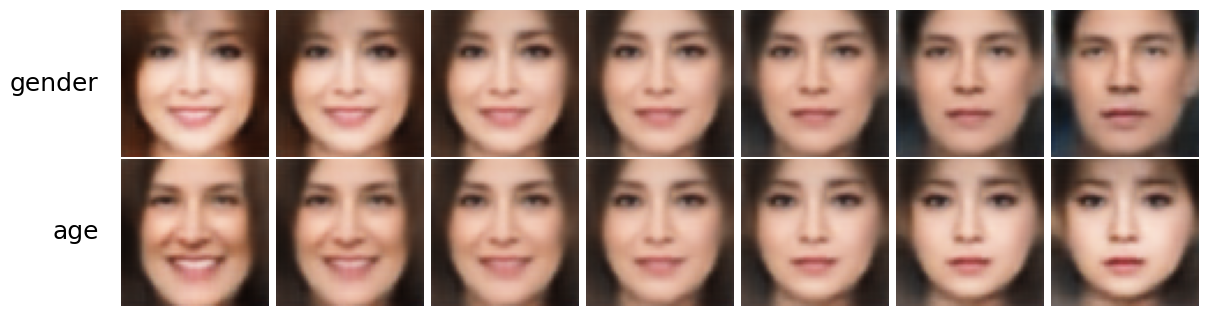

In [21]:
# Adjusting the weights of the first layer of the decoder to handle the rotated latent space
W_adjusted = np.dot(R.T, W)
decoder.layers[1].set_weights([W_adjusted, bias])

selected_attributes = ['gender','age']

# Latent traversal range
traversal_range = 10
steps = 7
linspace = np.linspace(-traversal_range, traversal_range, steps)

# Setup plot: 2 rows, tightly spaced
fig, axes = plt.subplots(2, steps, figsize=(14, 4),
                         gridspec_kw={'wspace': 0.00, 'hspace': 0.01})

for dim in [0, 1]:
    for i, val in enumerate(linspace):
        z = Z_val_orth_rotated[3, :].copy()
        z[dim] += val

        z_tensor = np.expand_dims(z, axis=0)
        decoded_image = decoder.predict(z_tensor, verbose=0)[0]
        decoded_image = np.clip(decoded_image, 0, 1)

        ax = axes[dim, i]
        ax.imshow(decoded_image)
        ax.axis('off')

        if i == 0:
            ax.set_ylabel(f'Dim {dim}', fontsize=12, rotation=90, labelpad=10)

# Add attribute labels
for row in range(2):
    ax = axes[row, 0]
    ax.text(
        -0.15, 0.5,
        selected_attributes[row], 
        va='center', ha='right',
        fontsize=18, transform=ax.transAxes
    )

plt.subplots_adjust(wspace=0.01, hspace=0.05, top=0.85)
plt.savefig('cae_latent_space_traversal_utkface_orth.jpg')
plt.show()

# Latent space traversal (Oblique rotation)

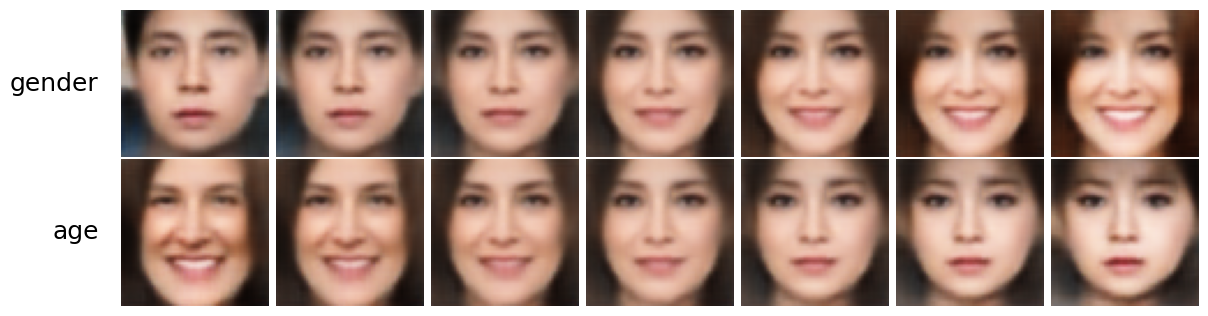

In [22]:
# Adjusting the weights of the first layer of the decoder to handle the rotated latent space
R_prime_inv = np.linalg.inv(R_prime)
W_adjusted = np.dot(R_prime_inv, W)
decoder.layers[1].set_weights([W_adjusted, bias])

selected_attributes = ['gender','age']

# Latent traversal range
traversal_range = 10
steps = 7
linspace = np.linspace(-traversal_range, traversal_range, steps)

# Setup plot: 2 rows, tightly spaced
fig, axes = plt.subplots(2, steps, figsize=(14, 4),
                         gridspec_kw={'wspace': 0.00, 'hspace': 0.01})

for dim in [0, 1]:
    for i, val in enumerate(linspace):
        z = Z_val_obl_rotated[3, :].copy()
        z[dim] += val

        z_tensor = np.expand_dims(z, axis=0)
        decoded_image = decoder.predict(z_tensor, verbose=0)[0]
        decoded_image = np.clip(decoded_image, 0, 1)

        ax = axes[dim, i]
        ax.imshow(decoded_image)
        ax.axis('off')

        if i == 0:
            ax.set_ylabel(f'Dim {dim}', fontsize=12, rotation=90, labelpad=10)

# Add attribute labels
for row in range(2):
    ax = axes[row, 0]
    ax.text(
        -0.15, 0.5,
        selected_attributes[row], 
        va='center', ha='right',
        fontsize=18, transform=ax.transAxes
    )

plt.subplots_adjust(wspace=0.01, hspace=0.05, top=0.85)
plt.savefig('cae_latent_space_traversal_utkface_obl.jpg')
plt.show()